In [1]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import nilearn

from matplotlib.colors import colorConverter
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi, plot_img, plot_anat
from scipy.spatial.distance import directed_hausdorff
from nipype.algorithms.metrics import Distance
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from scipy import interp
from itertools import chain
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening
from skimage.morphology import cube, octahedron, ball

In [2]:
# Set working directory
os.chdir('/home/uziel/DISS')
test_flag = 0

In [3]:
#List all sequences per subject
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'

subjects_paths = sorted(os.listdir(root))
channels_per_subject = dict() # groups relevant sequences per subject
for i in range(len(subjects_paths)):
    s_path = os.path.join(root, subjects_paths[i])
    channels_per_subject[i] = [y
                               for x in os.walk(s_path)
                               for y in
                               glob(os.path.join(x[0], '*ADC*.nii')) or
                               glob(os.path.join(x[0], '*MTT*.nii')) or
                               glob(os.path.join(x[0], '*rCBF*.nii')) or
                               glob(os.path.join(x[0], '*rCBV*.nii')) or
                               glob(os.path.join(x[0], '*Tmax*.nii')) or
                               glob(os.path.join(x[0], '*TTP*.nii')) or
                               glob(os.path.join(x[0], '*OT*.nii'))
                              ]


In [ ]:
# Resample images to same voxel size
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'

# define template path
template_path = './data/MNI152_T1_1mm_brain.nii.gz'
# define downsample factor
dF = 0.7

# remove and create dir for processed data
if os.path.exists(root): shutil.rmtree(root)
os.makedirs(root)

# load template image
template = nib.load(template_path)

for subject in channels_per_subject.keys():
    # create subdirectory per subject
    subject_root = os.path.join(root, str(subject))
    os.mkdir(subject_root)
    
    subject_imgs = []
    # Resample img to match template (1mm voxel size / dF)
    for channel_file in channels_per_subject[subject]:
        if 'OT' in channel_file:            
            # label must be resampled using nearest neighbour
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='nearest')
        else:
            resampled_img = resample_img(channel_file,
                                         template.affine[:3,:3]/dF,
                                         interpolation='continuous')

        subject_imgs.append([resampled_img, channel_file])
        
    # compute subject brain mask given all original channels (ignore label channel)
    mask = compute_background_mask([y for x,y in subject_imgs if not 'OT' in y])
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj, iterations=2)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # resample mask to match template
    mask = resample_img(mask,
                        template.affine[:3,:3]/dF,
                        interpolation='nearest')
    # dilate mask to adjust better to boundaries
    dilated_mask_data = ndimage.binary_dilation(mask.dataobj)
    mask = nib.nifti1.Nifti1Image(mask.dataobj.astype(np.int32), mask.affine)
    # save mask
    nib.save(mask, os.path.join(subject_root, 'mask.nii.gz'))
   
    # standarize each image within mask and save
    # to zero-mean and unit variance
    for img, channel_file in subject_imgs:
        # don't try to normalize label channel
        if 'OT' not in channel_file:
            # get data within mask
            temp_data = img.dataobj * mask.dataobj
            # compute mean and variance of non-zero values
            mean = np.mean(temp_data[np.nonzero(temp_data)])
            std = np.std(temp_data[np.nonzero(temp_data)])
            # substract mean and divide by std all non-zero values
            temp_data[np.nonzero(temp_data)] = (temp_data[np.nonzero(temp_data)] - mean) / std
            # build standarize image with standarize data and unmodified affine
            img = nib.nifti1.Nifti1Image(temp_data.astype(np.float32), img.affine)
        else:
            img = nib.nifti1.Nifti1Image(img.get_data().astype(np.int32), img.affine)

        # save image
        file_name = os.path.basename(channel_file)
        nib.save(img, os.path.join(subject_root, file_name) + '.gz')
      
    print("Subject " + str(subject) + " finished.")


In [ ]:
def data_to_file(data, path):
    out = open(path, "w")
    for line in data:
        print >> out, line
    out.close()

In [ ]:
# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
# channels - sequences os.path.join('../../../../../../', x) needed for deepmedic
channels['Channels_ADC'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([os.path.join('../../../../../../', y)
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([os.path.join('../../../../../../', y)
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([os.path.join('../../../../../../', y)
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])


In [ ]:
####################################################################
##### FILES FOR DM_V0 (BASELINE) AND TRANSFER LEARNING VARIANT #####
####################################################################
# set base config path
root_base = './ischleseg/deepmedic/versions/DM_V0_base'
root_base_transfer = './ischleseg/deepmedic/versions/DM_V0_transfer_base'

# k-fold cross-validation in training data, ignore test data for now
# k = 5
k = 5

# random subject indices
indices = range(len(channels['Channels_ADC']))
random.shuffle(indices)
# Divide subject indices in 5 equally sized chunks
chunk_size = int(np.ceil(len(indices)/float(k)))
subjects_all = [indices[i:i + chunk_size]
                for i in xrange(0, len(indices), chunk_size)]

# for each iteration, choose:
# ... 3 chunks for training
# ... 1 chunk for validation
# ... 1 chunk for test
for i in range(k):
    subjects_training = subjects_all[i % k] + subjects_all[(i+1) % k] + subjects_all[(i+2) % k]
    subjects_validation = subjects_all[(i+3) % k]
    subjects_test = subjects_all[(i+4) % k]
    
    # set model variant dir
    s_path = os.path.join(os.path.dirname(root_base), 'DM_V0_' + str(i))
    s_path_transfer = os.path.join(os.path.dirname(root_base_transfer), 'DM_V0_transfer_' + str(i))
    # make model variant dir
    if not os.path.exists(s_path): shutil.copytree(root_base, s_path)
    if not os.path.exists(s_path_transfer): shutil.copytree(root_base_transfer, s_path_transfer)

    # set model variant config dirs
    test_path = os.path.join(s_path, 'configFiles/test')
    test_path_transfer = os.path.join(s_path_transfer, 'configFiles/test')
    train_path = os.path.join(s_path, 'configFiles/train')
    train_path_transfer = os.path.join(s_path_transfer, 'configFiles/train')
    validation_path = os.path.join(s_path, 'configFiles/validation')
    validation_path_transfer = os.path.join(s_path_transfer, 'configFiles/validation')

    # make model variant config dirs
    if not os.path.exists(test_path): os.makedirs(test_path)
    if not os.path.exists(test_path_transfer): os.makedirs(test_path_transfer)
    if not os.path.exists(train_path): os.makedirs(train_path)
    if not os.path.exists(train_path_transfer): os.makedirs(train_path_transfer)
    if not os.path.exists(validation_path): os.makedirs(validation_path)
    if not os.path.exists(validation_path_transfer): os.makedirs(validation_path_transfer)
    
    for name, files in channels.iteritems():
        # save train channel files
        data_to_file([files[j] for j in subjects_training], os.path.join(train_path, 'train' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_training], os.path.join(train_path_transfer, 'train' + name + '.cfg'))
        # save validation channel files
        data_to_file([files[j] for j in subjects_validation], os.path.join(validation_path, 'validation' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_validation], os.path.join(validation_path_transfer, 'validation' + name + '.cfg'))
        # save test channel files
        data_to_file([files[j] for j in subjects_test], os.path.join(test_path, 'test' + name + '.cfg'))
        data_to_file([files[j] for j in subjects_test], os.path.join(test_path_transfer, 'test' + name + '.cfg'))

        # save names of predictions
        names = ['SMIR.ischleseg_' + 'DM_V0_' + str(i) + '.' + os.path.basename(x).split('.')[-3]
                 for x in [channels['Channels_MTT'][j] for j in subjects_test]]
        data_to_file(names, os.path.join(test_path, 'testNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(test_path_transfer, 'testNamesOfPredictions.cfg'))

        # save names of predictions
        names = ['SMIR.ischleseg_' + 'DM_V0_' + str(i) + '.' + os.path.basename(x).split('.')[-3]
                 for x in [channels['Channels_MTT'][j] for j in subjects_validation]]
        data_to_file(names, os.path.join(validation_path, 'validationNamesOfPredictions.cfg'))
        data_to_file(names, os.path.join(validation_path_transfer, 'validationNamesOfPredictions.cfg'))

# modelConfig,cfg, trainConfig.cfg and testConfig.cfg must be added and modified manually.


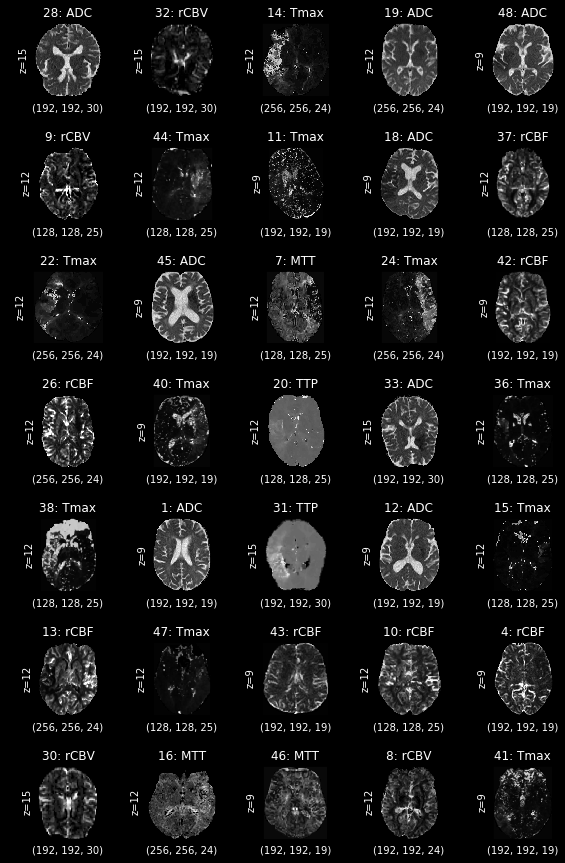

In [176]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii'))
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii'))
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii'))
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii'))
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii'))
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii'))
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii'))
                              ])
# subjects
subject_names = [x.split('/')[4] for x in channels['Channels_ADC']]

n = 35
# chosen subjects
subjects = random.sample(range(len(subject_names)), n)
# chosen channels
available_channels = [x for x in channels.keys() if 'Labels' not in x]
subjects_channels = [random.choice(available_channels) for i in range(n)]

plt.close('all')
fig = plt.figure(figsize=(10, 15))
for i in range(n):
    data = nib.load(channels[subjects_channels[i]][subjects[i]]).get_data()
    
    # Set cut coordinates
    cut_coords = data.shape[2]/2
    # Find best bounding box
    data_2d = data[:,:,cut_coords]
    idx = np.nonzero(data_2d)
    # row_min, row_max, col_min, col_max
    bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])]    
    
    ax = fig.add_subplot(n/5, 5, i+1)
    ax.imshow(data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T, 'gray', interpolation='none')
    ax.set_ylabel('z=%d' % cut_coords, color='w')
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel(data.shape, color='w')
    ax.xaxis.set_label_coords(0.5, -0.1) 
    ax.set_title(subject_names[subjects[i]].split('_')[1] + ': ' + subjects_channels[i].split('_')[1], color='w')
    
    
fig.patch.set_facecolor('xkcd:black')
fig.subplots_adjust(wspace=0.1, hspace=0.7)
fig.savefig('data_original_example.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

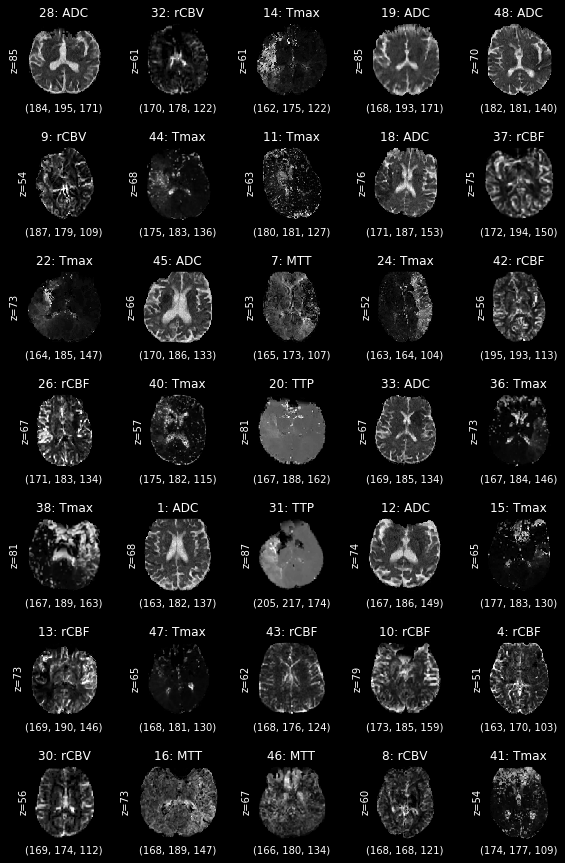

In [179]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])

# subjects
subject_names_processed = [x.split('/')[4] for x in channels['Channels_ADC']]

cmap = plt.cm.gray
cmap.set_bad(color='black')
cmap.set_under(color='black')

plt.close('all')
fig = plt.figure(figsize=(10, 15))
for i in range(n):
    subject_processed = np.argwhere(np.array(subject_names_processed) == str(subjects[i]))[0][0]
    data = nib.load(channels[subjects_channels[i]][subject_processed]).get_data()
    
    # Set cut coordinates
    cut_coords = data.shape[2]/2    
    # Find best bounding box
    data_2d = data[:,:,cut_coords]
    idx = np.nonzero(data_2d)
    # row_min, row_max, col_min, col_max
    bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])]    
    
    ax = fig.add_subplot(n/5, 5, i+1)
    tmp = data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords]
    tmp = np.rot90(tmp, 1)
    tmp = np.ma.masked_where(tmp == 0, tmp)
    ax.imshow(tmp, cmap=cmap, interpolation='none')
    ax.set_ylabel('z=%d' % cut_coords, color='w')
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel(data.shape, color='w')
    ax.xaxis.set_label_coords(0.5, -0.1)    
    ax.set_title(subject_names[subjects[i]].split('_')[1] + ': ' + subjects_channels[i].split('_')[1], color='w')
    
    
fig.patch.set_facecolor('xkcd:black')
fig.subplots_adjust(wspace=0.1, hspace=0.7)
fig.savefig('data_processed_example.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

**PLOT ORIGINAL CHANNELS**

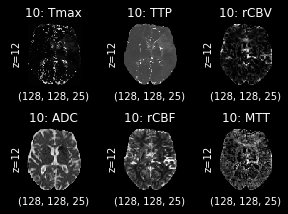

In [55]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data/ISLES2017/testing'
else:
    root = './data/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii'))
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii'))
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii'))
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii'))
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii'))
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii'))
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii'))
                              ])
# subjects
subject_names = [x.split('/')[4] for x in channels['Channels_ADC']]

# chosen subjects
subject = 1
# chosen channels
subject_channels = [x for x in channels.keys() if 'GtLabels' not in x]

plt.close('all')
fig = plt.figure(figsize=(5, 5))
for i in range(len(subject_channels)):
    data = nib.load(channels[subject_channels[i]][subject]).get_data()
    
    # Set cut coordinates
    cut_coords = data.shape[2]/2
    # Find best bounding box
    data_2d = data[:,:,cut_coords]
    idx = np.nonzero(data_2d)
    # row_min, row_max, col_min, col_max
    bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])]    
    tmp = data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords].T
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(tmp, 'gray', interpolation='none')
    ax.set_ylabel('z=%d' % cut_coords, color='w')
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel(data.shape, color='w')
    ax.xaxis.set_label_coords(0.5, -0.1) 
    ax.set_title(subject_names[subject].split('_')[1] + ': ' + subject_channels[i].split('_')[1], color='w')
    
    
fig.patch.set_facecolor('xkcd:black')
fig.subplots_adjust(wspace=0.1, hspace=0.7)
fig.savefig('data_original_example.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

**PLOT AUGMENTED CHANNELS**

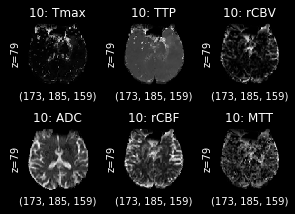

In [63]:
####################################
##### TEST PREPROCESSING FILES #####
####################################

# Generate files listing all images per channel
if test_flag:
    root = './data_processed/ISLES2017/testing'
else:
    root = './data_processed/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii.gz'))
                                   if 'clone' not in y
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii.gz'))
                                    if 'clone' not in y
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii.gz'))
                                   if 'clone' not in y
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii.gz'))
                               if 'clone' not in y
                              ])
# masks
channels['RoiMasks'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], 'mask.nii.gz'))
                               if 'clone' not in y
                              ])

# subjects
subject_names_processed = [x.split('/')[4] for x in channels['Channels_ADC']]

cmap = plt.cm.gray
cmap.set_bad(color='black')
cmap.set_under(color='black')

# chosen subjects
subject = 1
# chosen channels
subject_channels = [x for x in channels.keys() if 'GtLabels' not in x and 'Mask' not in x]

plt.close('all')
fig = plt.figure(figsize=(5, 5))
for i in range(len(subject_channels)):
    subject_processed = np.argwhere(np.array(subject_names_processed) == str(subject))[0][0]
    data = nib.load(channels[subject_channels[i]][subject_processed]).get_data()
    
    # Set cut coordinates
    cut_coords = data.shape[2]/2
    # Find best bounding box
    data_2d = data[:,:,cut_coords]
    idx = np.nonzero(data_2d)
    # row_min, row_max, col_min, col_max
    bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])]    
    
    ax = fig.add_subplot(3, 3, i+1)
    tmp = data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords]
    tmp = np.rot90(tmp, 1)
    tmp = np.ma.masked_where(tmp == 0, tmp)
    ax.imshow(tmp, cmap=cmap, interpolation='none')
    ax.set_ylabel('z=%d' % cut_coords, color='w')
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel(data.shape, color='w')
    ax.xaxis.set_label_coords(0.5, -0.1) 
    ax.set_title(subject_names[subject].split('_')[1] + ': ' + subject_channels[i].split('_')[1], color='w')
    
    
fig.patch.set_facecolor('xkcd:black')
fig.subplots_adjust(wspace=0.1, hspace=0.7)
fig.savefig('data_processed_example.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())

**PLOT ONE EXAMPLE OF EACH LESION CATEGORY**

Print ADC channels with GT overlay from subjects 9 (lacunar), 21 (small cortical) and 14 (big cortical)

In [4]:
# Generate files listing all images per channel
root = './data/ISLES2017/training'
    
channels = {}
channels['Channels_ADC'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*ADC*.nii'))
                                  ])
channels['Channels_MTT'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*MTT*.nii'))
                                  ])
channels['Channels_rCBF'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBF*.nii'))
                                  ])
channels['Channels_rCBV'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*rCBV*.nii'))
                                  ])
channels['Channels_Tmax'] = sorted([y
                                    for x in os.walk(root)
                                    for y in glob(os.path.join(x[0], '*Tmax*.nii'))
                                  ])
channels['Channels_TTP'] = sorted([y
                                   for x in os.walk(root)
                                   for y in glob(os.path.join(x[0], '*TTP*.nii'))
                                  ])
# labels
channels['GtLabels'] = sorted([y
                               for x in os.walk(root)
                               for y in glob(os.path.join(x[0], '*OT*.nii'))
                              ])

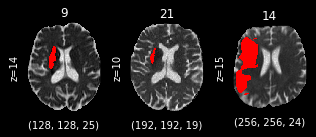

In [52]:
# subjects
plot_subjects = ['9', '21', '14']
cut_coords = [14, 10, 15]
subject_names_processed = [x.split('/')[4] for x in channels['Channels_ADC']
                           if x.split('/')[4].split('_')[-1] in plot_subjects][::-1]

# chosen channels
subject_adc = [x for x in channels['Channels_ADC'] if x.split('/')[4] in subject_names_processed][::-1]
subject_gt = [x for x in channels['GtLabels'] if x.split('/')[4] in subject_names_processed][::-1]

cmap = plt.cm.gray
cmap.set_bad(color='black')
cmap.set_under(color='black')

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red'],256)

cmap1._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap1.N+3)
cmap1._lut[:,-1] = alphas

plt.close('all')
fig = plt.figure(figsize=(5, 15))
for i in range(len(plot_subjects)):
    data = nib.load(subject_adc[i]).get_data()
    gt = nib.load(subject_gt[i]).get_data()

    # Find best bounding box
    data_2d = data[:,:,cut_coords[i]]
    idx = np.nonzero(data_2d)
    # row_min, row_max, col_min, col_max
    bbox = [np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])]    
    
    # Plot adc
    ax = fig.add_subplot(1, 3, i+1)
    tmp = data[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords[i]].T
    tmp = np.ma.masked_where(tmp == 0, tmp)
    ax.imshow(tmp, 'gray', interpolation='none')
    
    # Plot gt
    tmp = gt[bbox[0]:bbox[1],bbox[2]:bbox[3],cut_coords[i]].T
    tmp = np.ma.masked_where(tmp == 0, tmp)
    ax.imshow(tmp, cmap='autumn', interpolation='none')
    
    ax.set_ylabel('z=%d' % cut_coords[i], color='w')
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel(data.shape, color='w')
    ax.xaxis.set_label_coords(0.5, -0.1) 
    ax.set_title(plot_subjects[i], color='w')    
    
fig.patch.set_facecolor('xkcd:black')
fig.subplots_adjust(wspace=0.4, hspace=0.7)
fig.savefig('lesion_categories_examples.pdf', bbox_inches='tight', facecolor=fig.get_facecolor())